# MD Projections

In [1]:
import pytraj as pyt
import pandas as pd
import numpy as np
import gc
import sys
from glob import glob
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plot
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plot.rcParams.update(params)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', font_scale = 1.4)

## CDK2 Atom Masks

In [4]:
from helper_modules.protein_subsequences import get_pisani_residues, \
                get_pocket_residues, get_secondary_structure_residues

# Create the atom selection masks
mask_secnd_strc = '(:' + get_secondary_structure_residues(sep = ',') + ')&(@CA)'
mask_pisani     = '(:' + get_pisani_residues(sep = ',') + ')&(@CA)'
mask_pkt_Ca     = '(:' + get_pocket_residues(sep = ',') + ')&(@CA)'
mask_pkt_noHs   = '(:' + get_pocket_residues(sep = ',') + ')&!(@H=)'

In [5]:
MASK = mask_pkt_noHs

## Reference Structure
- `1fin` structure (with no Hydrogens) will be used as the reference structure to compute the trajectory alignments.

In [6]:
CRYS_DIR = '../../data/crystal_confs/'
ref_top_path = f'{CRYS_DIR}/pdb_modeled/1fin_A_mod.pdb'
ref_conf = pyt.load(ref_top_path, 
                    ref_top_path)
ref_conf

pytraj.Trajectory, 1 frames: 
Size: 0.000054 (GB)
<Topology: 2398 atoms, 298 residues, 1 mols, non-PBC>
           

## Crystallographic Ensemble
- Load the crystal structures metadata
- Load the crystal structures as a "trajectory": `crys_traj`

In [7]:
#******************************
# Crystal structures metadata
#******************************
prot_name = 'cdk2'
file = f'../1_Crystal_Structures/df_metadata_{prot_name}_pdbids_LIGS_CONF-LABELS.pkl'
df_prot = pd.read_pickle(file)
# keep only the relevant columns
columns = ['PDB_ID', 'Entities', 'Resolution', 
           'LigPktName', 'LigMW', 'LigNHeavyAtoms', 
           'ConfTypeLabel']
df_prot = df_prot[columns]

#******************************
# Crystal structures "trajectory"
#******************************
CRYS_DIR = '../../data/crystal_confs/'
# Create a crystallographic ensemble (pseudo trajectory)
ENS_CONFS_DIR = f'{CRYS_DIR}/pdb_modeled/'
input_files = sorted(glob(f'{ENS_CONFS_DIR}/*_A_mod.pdb'))

# Make sure that the order of conformations  
# in `input_files` and `pdb_ids` is the same
input_files_basenames = [i.split('/')[-1]\
                         .replace('_A_mod.pdb', '') 
                         for i in input_files]
assert np.all(df_prot['PDB_ID'] == input_files_basenames)

# Reference structure
top_path_crys  = f'{CRYS_DIR}/pdb_modeled/1fin_A_mod.pdb'
# Load the trajectory using pytraj
crys_traj = pyt.iterload(input_files, 
                         top = top_path_crys)
crys_traj

pytraj.TrajectoryIterator, 418 frames: 
Size: 0.022405 (GB)
<Topology: 2398 atoms, 298 residues, 1 mols, non-PBC>
           

## Molecular Dynamics Trajectories

In [8]:
%%time
import itertools as it
import parmed

STRIDE_MD = 5
MD_DIR  = '../../data/md_trajectories/'
SYSTEMS = ['WAT', 'LIG', 'ETA', 'ISO', 'MAM']
PDB_IDS = ['1fin', '4fku', '3pxf', '5a14']
REPS    = [1, 2, 3]
MD_FILE_BASENAME = 'md_protein_HvyAtms'

# List the name of `.trr` files
all_systems = list(it.product(PDB_IDS, SYSTEMS, REPS))
all_systems_md_trr = [f'{MD_DIR}/{system}_systems/rep_{rep}/' +
                      f'{pdb_id}/md/{MD_FILE_BASENAME}.trr'
                      for pdb_id, system, rep in all_systems]

#******************************
#     MD prod trajectories
#******************************
# Use `iterload` to avoid memory issues
# top_path  = f'../../data/md_trajectories/WAT_systems/rep_1/1fin/md/md_protein_HvyAtms.gro'
# top = pyt.io.load_parmed(parmed.load_file(top_path), traj = False)
md_trajs = pyt.load(all_systems_md_trr, 
                        top = top_path_crys,
                        stride = STRIDE_MD)
# Remove `topology` freames: when using a `trr` traj with a `pdb` as a
# topology file, `pytraj` appends the `pdb` structure at the end
# of each traj, we need to remove it
confs_per_rep = int(md_trajs.n_frames / len(all_systems))
print(confs_per_rep)
remained_frames = list(range(md_trajs.n_frames))
del remained_frames[::confs_per_rep]
md_trajs = md_trajs[remained_frames] # Slice
# Update confs_per_rep
confs_per_rep = int(md_trajs.n_frames / len(all_systems))
# Create a dataframe with the label of each MD conformation
# N systems
labels = []
for i in all_systems:
    for j in [i]*int(confs_per_rep):
        labels.append(j)
df_md_projs = pd.DataFrame(labels, 
                columns = ['Conf.', 'MD-Protocol', 'Rep.'])

md_trajs

801
CPU times: user 10.2 s, sys: 19.1 s, total: 29.4 s
Wall time: 2min 1s


pytraj.Trajectory, 48000 frames: 
Size: 2.572775 (GB)
<Topology: 2398 atoms, 298 residues, 1 mols, non-PBC>
           

# MD Projections using PCA

In [9]:
type_confs_names  = ['inact_src', 'active', 'inact_ope', 'dfg_out']
pdbid_confTypes = {'1fin': 'active', '4fku': 'inact_src', 
                       '3pxf': 'inact_ope', '5a14': 'dfg_out'}
ref_confs_colors  = ['#3DB8C1', '#EB5F5F',  '#FAB332', '#B389FA']
conf_label_colors = dict(zip(type_confs_names, ref_confs_colors))

In [10]:
from pca_helpers import get_coords, get_pca_projs, plot_projection, \
           plot_explained_variance  

def plot_initial_confs(ax, pca, 
                       edgecolor = 'black', 
                       textcolor = 'black',
                       xy_text_displace = (0.3, 0.3),
                       components_to_plot = (0, 2),
                       **text_kwargs):
    # Project crystal confs
    init_confs_idx = [input_files_basenames.index(i) 
                      for i in PDB_IDS]
    TRAJ = crys_traj[init_confs_idx]
    sup_coords = get_coords(traj = TRAJ, 
                            mask = MASK, 
                            ref_conf = ref_conf)
    # Use the PCA defined by the MD confs to project
    # the four initial structures
    x, y = pca.transform(sup_coords).T[:2]
    sns.scatterplot(
        x = x, y = y,
        linewidth = 2, edgecolor = edgecolor,
        facecolors = 'cyan',ax = ax
    )
    for x, y, conf in zip(x, y, PDB_IDS):
        ax.text(x + xy_text_displace[0], 
                y + xy_text_displace[1], 
                 s = conf, fontweight = 'bold', 
                 c = textcolor, **text_kwargs)
    return ax

# K-means clustering
- Using Pocket selection
- Get the PCA projection and the scree plot
- Use the first $p$ PCs as the input features for k-Means Clustering
- Perform k-Mean over the conformations of each system independently:
    - Use k = 30

In [11]:
from k_means_helpers import get_medoid_confs

## PCA projections using MD confs

### Pisani Selection

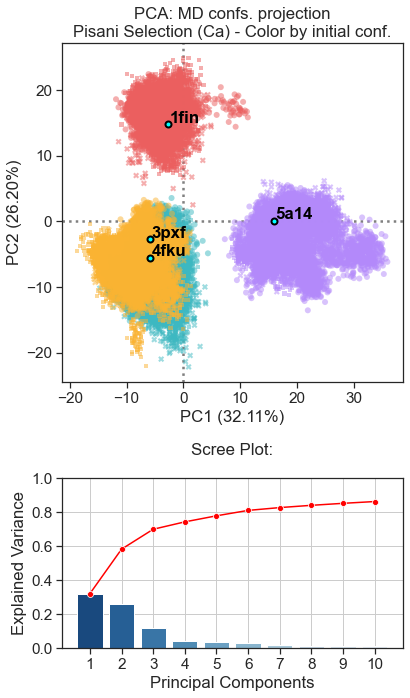

In [12]:
TRAJ    = md_trajs
MASK    = mask_pisani
STRIDE  = 1 # STRIDE_MD * STRIDE
COL_HUE = 'Conf.'
DF_PLOT = df_md_projs.replace(pdbid_confTypes)
PLOT_TITLE = 'PCA: MD confs. projection\nPisani Selection (Ca)' +\
             ' - Color by initial conf.'

fig, axs = plt.subplots(2, 1, figsize = (6, 10),
                       gridspec_kw={'height_ratios':[2,1]})
mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
df_proj, exp_vars, pca = get_pca_projs(mtx_coords = mtx_coords, 
                                  df_labels = DF_PLOT, 
                                  stride = STRIDE,
                                  n_components = 10)
axs[0] = plot_projection(df = df_proj, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     style = 'Rep.', legend = False,
                     palette = conf_label_colors, ax = axs[0])

# Highlight initial conformations
# Project crystal confs
plot_initial_confs(ax = axs[0], pca = pca)

# Scree plot
plot_explained_variance(pca_obj = pca, ax = axs[1])
plt.tight_layout()
plt.show()

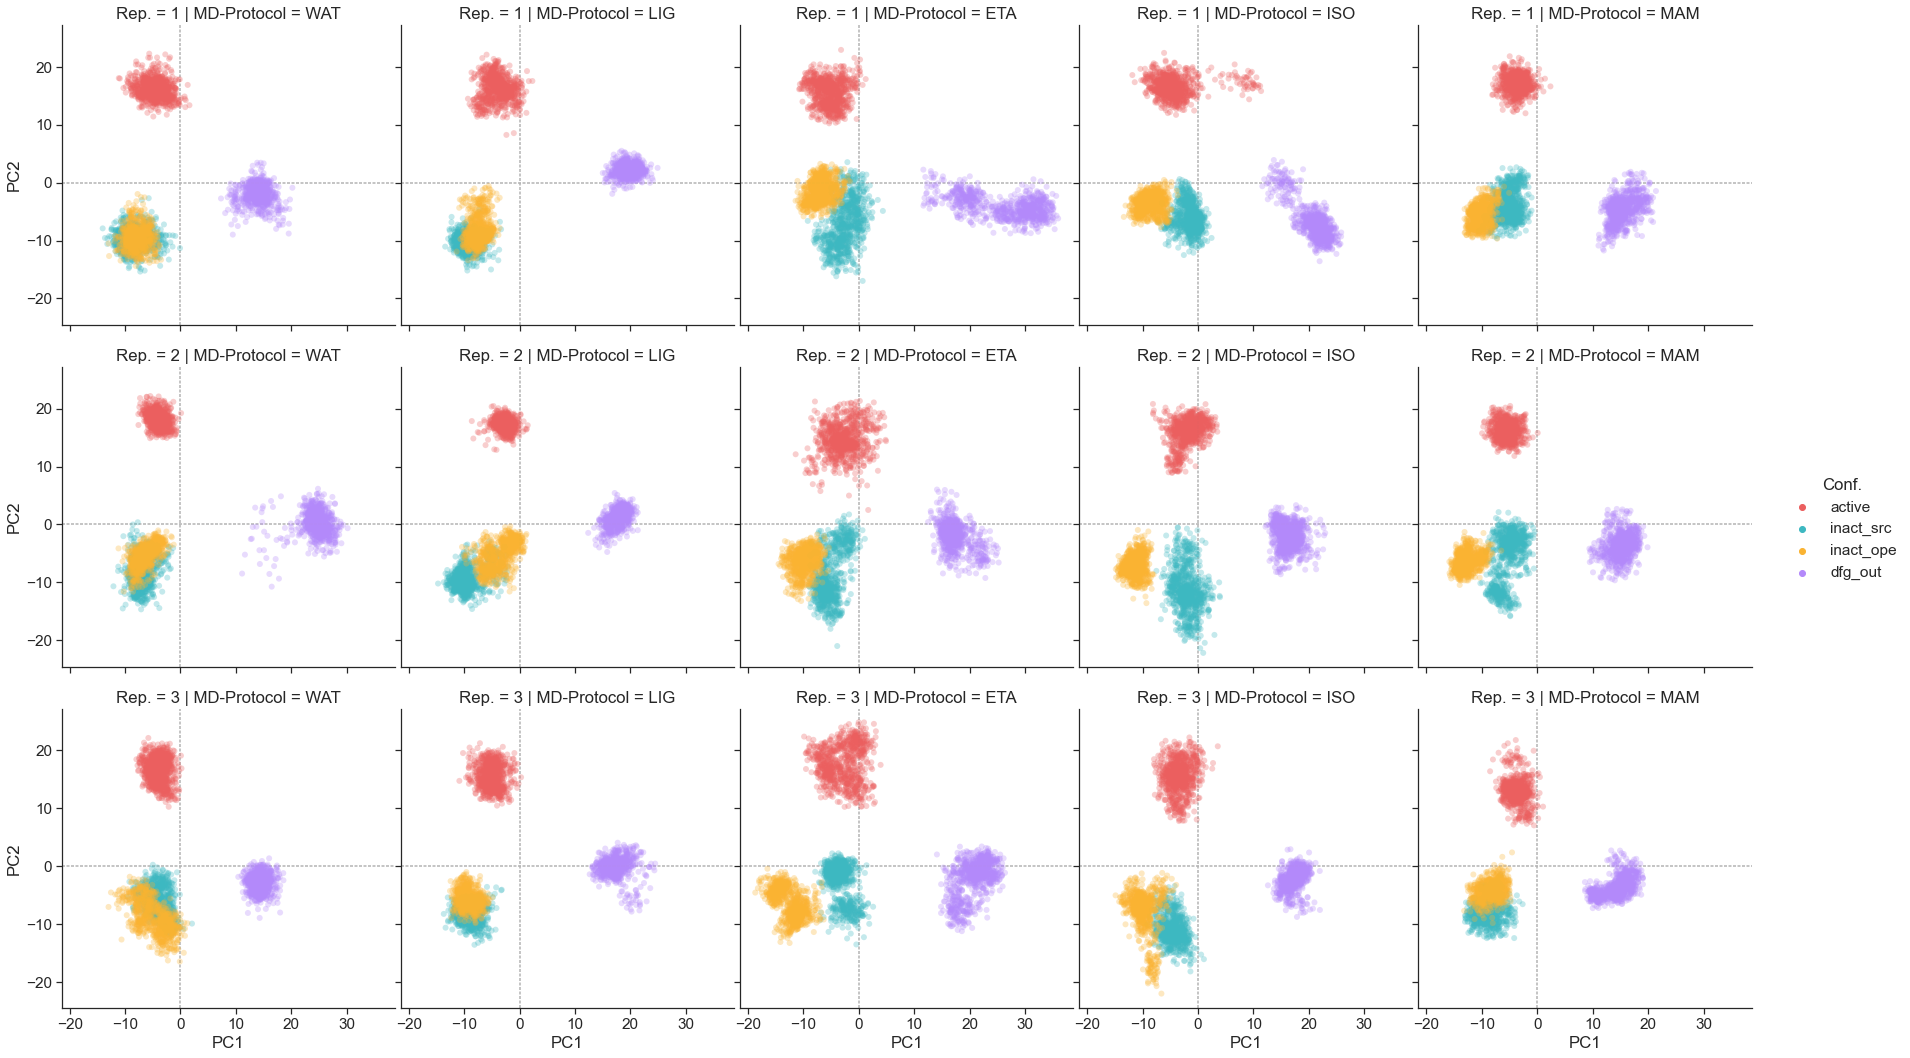

In [13]:
g = sns.relplot(x= 1, y= 2,
                hue="Conf.", 
                row = "Rep.", 
                col = 'MD-Protocol',
                kind = 'scatter',
                palette = conf_label_colors,
                linewidth = 0,
                alpha = 0.3,
                data = df_proj)
(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .map(plt.axvline, x=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("PC1", "PC2")
  .tight_layout(w_pad=0)
)

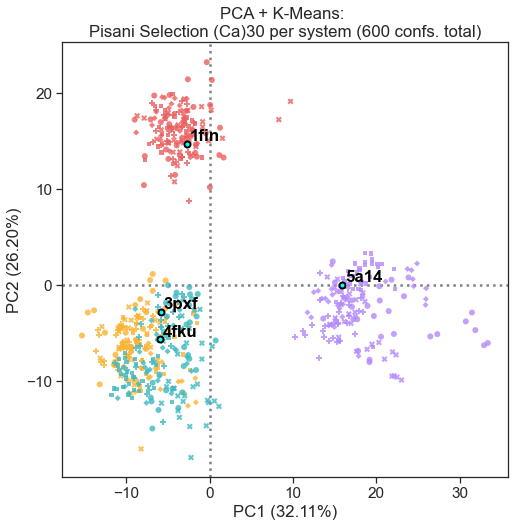

In [14]:
n_clusters = 30
n_components_to_use = 6
COL_HUE = 'Conf.'
DF_PROJ = df_proj[['Conf.', 'Rep.', 'MD-Protocol'] + \
               list(range(1, n_components_to_use + 1))]
PLOT_TITLE = 'PCA + K-Means: \nPisani Selection (Ca)' +\
             f'{n_clusters} per system ({n_clusters * 20} confs. total)'

df_meds = get_medoid_confs(df_all_systems=df_proj,
                 used_stride=STRIDE_MD,
                 n_clusters=30)

ax = plot_projection(df = df_meds, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     alpha = 0.8,
                     legend = False,
                     style = 'MD-Protocol',
                     palette = conf_label_colors)
plot_initial_confs(ax = ax, pca = pca)
plt.show()

In [15]:
# Save the dataframe with the medoid confs
proj_type = 'MDconfsOnMDconfs'
selection = 'Pisani'
filename  = f'./kMedoid_{proj_type}_{selection}Selection'
df_meds.to_pickle(filename)

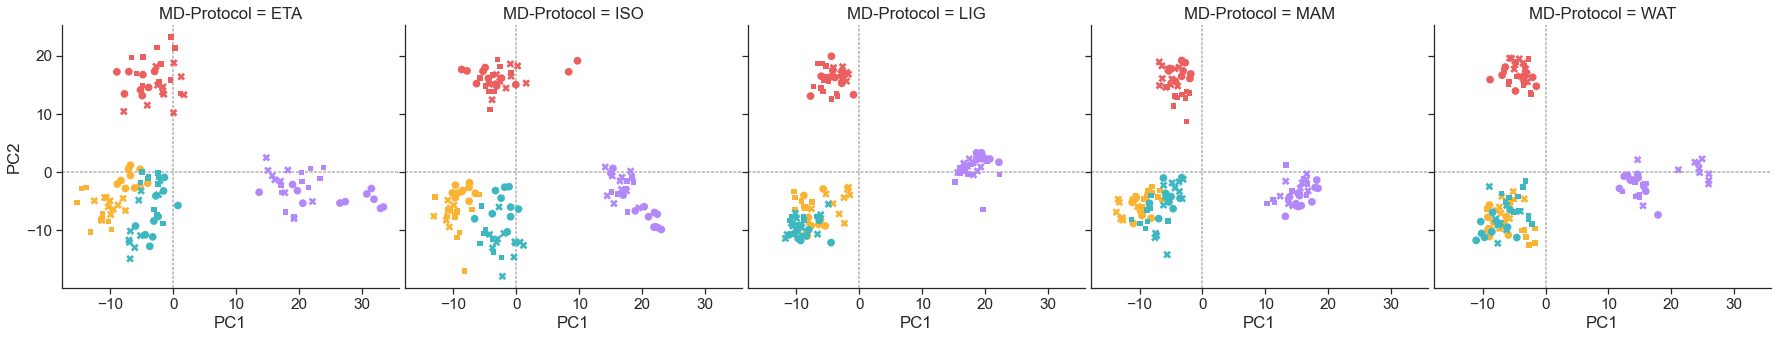

In [16]:
g = sns.relplot(x= 1, y= 2,
                hue="Conf.", 
                col = 'MD-Protocol',
                kind = 'scatter',
                style = 'Rep.',
                palette = conf_label_colors,
                linewidth = 0,
                alpha = 1,
                legend = False,
                s = 60,
                data = df_meds)
(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .map(plt.axvline, x=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("PC1", "PC2")
  .tight_layout(w_pad=0)
)

### Pocket Selection

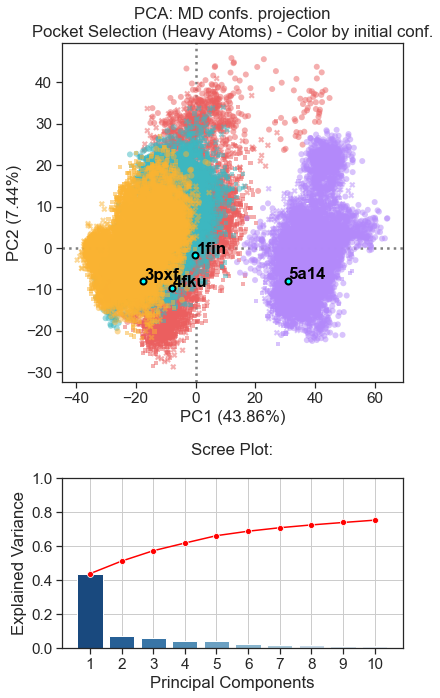

In [17]:
TRAJ    = md_trajs
MASK    = mask_pkt_noHs
STRIDE  = 1 # STRIDE_MD * STRIDE
COL_HUE = 'Conf.'
DF_PLOT = df_md_projs.replace(pdbid_confTypes)
PLOT_TITLE = 'PCA: MD confs. projection\nPocket Selection (Heavy Atoms)' +\
             ' - Color by initial conf.'

fig, axs = plt.subplots(2, 1, figsize = (6, 10),
                       gridspec_kw={'height_ratios':[2,1]})
mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
df_proj, exp_vars, pca = get_pca_projs(mtx_coords = mtx_coords, 
                                  df_labels = DF_PLOT, 
                                  stride = STRIDE,
                                  n_components = 10)
axs[0] = plot_projection(df = df_proj, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     style = 'Rep.', legend = False,
                     palette = conf_label_colors, ax = axs[0])

# Highlight initial conformations
# Project crystal confs
plot_initial_confs(ax = axs[0], pca = pca)

# Scree plot
plot_explained_variance(pca_obj = pca, ax = axs[1])
plt.tight_layout()
plt.show()

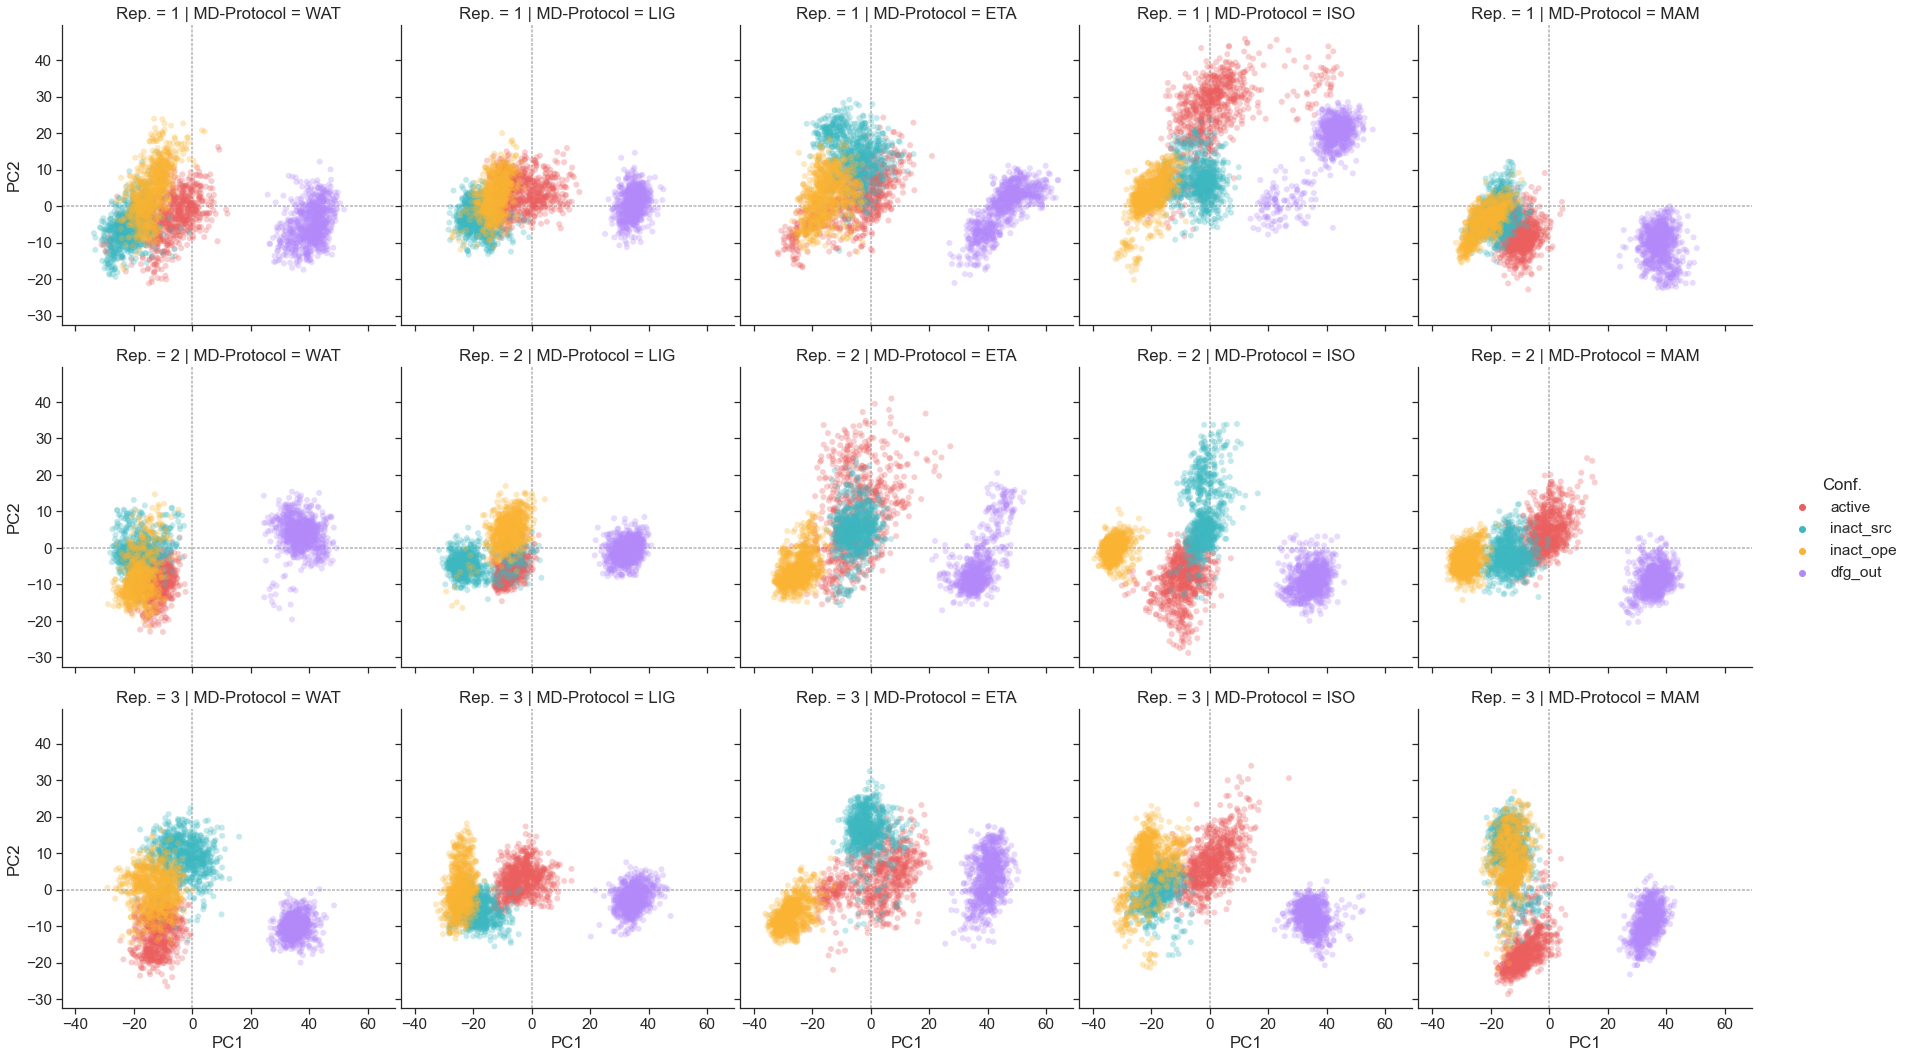

In [18]:
g = sns.relplot(x= 1, y= 2,
                hue="Conf.", 
                row = "Rep.", 
                col = 'MD-Protocol',
                kind = 'scatter',
                palette = conf_label_colors,
                linewidth = 0,
                alpha = 0.3,
                data = df_proj)
(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .map(plt.axvline, x=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("PC1", "PC2")
  .tight_layout(w_pad=0)
)

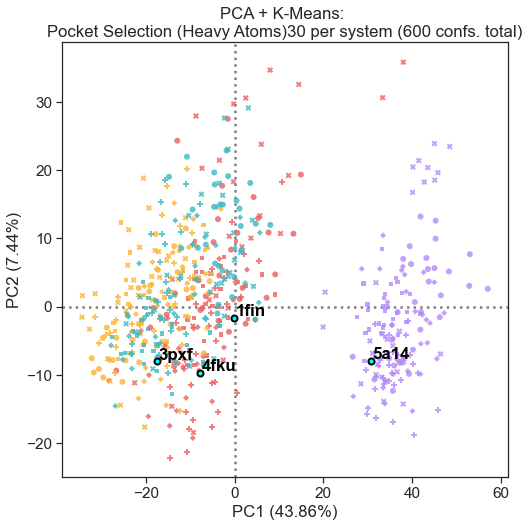

In [19]:
n_clusters = 30
n_components_to_use = 6
COL_HUE = 'Conf.'
DF_PROJ = df_proj[['Conf.', 'Rep.', 'MD-Protocol'] + \
               list(range(1, n_components_to_use + 1))]
PLOT_TITLE = 'PCA + K-Means: \nPocket Selection (Heavy Atoms)' +\
             f'{n_clusters} per system ({n_clusters * 20} confs. total)'

df_meds = get_medoid_confs(df_all_systems=DF_PROJ,
                 used_stride=STRIDE_MD,
                 n_clusters=30)

ax = plot_projection(df = df_meds, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     legend = False,
                     alpha = 0.8,
                     style = 'MD-Protocol',
                     palette = conf_label_colors)
plot_initial_confs(ax = ax, pca = pca)
plt.show()

In [20]:
# Save the dataframe with the medoid confs
proj_type = 'MDconfsOnMDconfs'
selection = 'Pocket'
filename  = f'./kMedoid_{proj_type}_{selection}Selection'
df_meds.to_pickle(filename)

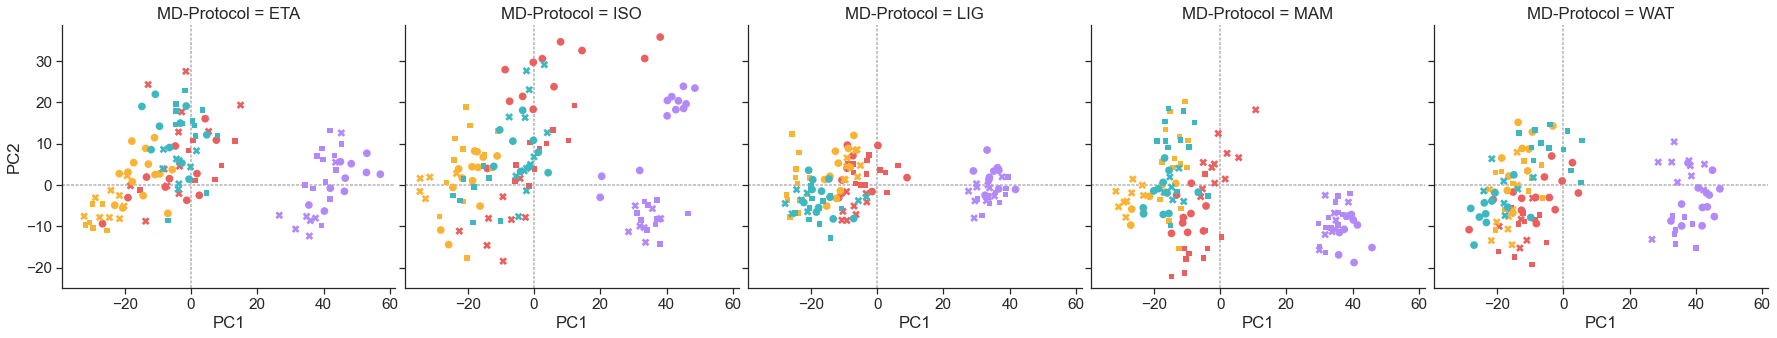

In [21]:
g = sns.relplot(x= 1, y= 2,
                hue="Conf.", 
                col = 'MD-Protocol',
                kind = 'scatter',
                style = 'Rep.',
                palette = conf_label_colors,
                linewidth = 0,
                alpha = 1,
                legend = False,
                s = 60,
                data = df_meds)
(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .map(plt.axvline, x=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("PC1", "PC2")
  .tight_layout(w_pad=0)
)

# Projections over defined subspaces (MD over CRYS)

## Pisani Selection

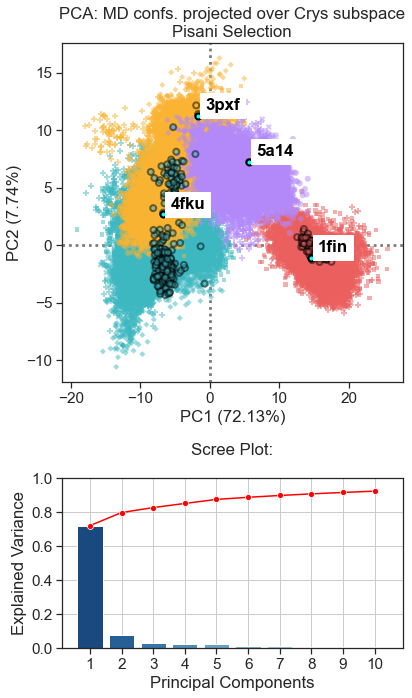

In [22]:
TRAJ    = crys_traj
MASK    = mask_pisani
STRIDE  = 1
DF_PLOT = df_prot[['PDB_ID', 'ConfTypeLabel']]
PLOT_TITLE = 'PCA: MD confs. projected over Crys subspace\n' +\
             'Pisani Selection'
n_components = 10
# Crys projection
mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
df_proj, exp_vars, pca = get_pca_projs(mtx_coords = mtx_coords, 
                                  df_labels = DF_PLOT, 
                                  stride = STRIDE,
                                  n_components = n_components)

# Project MD conformations
TRAJ = md_trajs
md_mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
md_projs = pca.transform(md_mtx_coords)
df_md = df_md_projs\
        .replace(pdbid_confTypes)[['Conf.', 'Rep.', 'MD-Protocol']]
df_md = pd.concat((df_md, 
                    pd.DataFrame(md_projs,
                    columns = range(1, n_components + 1),
                                )), 
                    axis = 1)
# Plot
fig, axs = plt.subplots(2, 1, figsize = (6, 10),
                       gridspec_kw={'height_ratios':[2,1]})
COL_HUE = 'Conf.'
plot_projection(df = df_md, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     style = 'MD-Protocol',
                     ax = axs[0],
                     legend = False,
                     palette = conf_label_colors)
COL_HUE = 'ConfTypeLabel'
plot_projection(df = df_proj, color_hue = COL_HUE,  
                 plot_title = PLOT_TITLE,
                 exp_vars = exp_vars, 
                 legend = False,
                 linewidth = 2, edgecolor = 'black',
                 palette = conf_label_colors, ax = axs[0])

# Reference conformations
plot_initial_confs(axs[0], pca, 
                   xy_text_displace = (1, 0.5),
                   bbox = dict(
                     boxstyle  = "square",
                     facecolor = 'white')
                   )
# Scree plot
plot_explained_variance(pca_obj = pca, ax = axs[1])
plt.tight_layout()
plt.show()

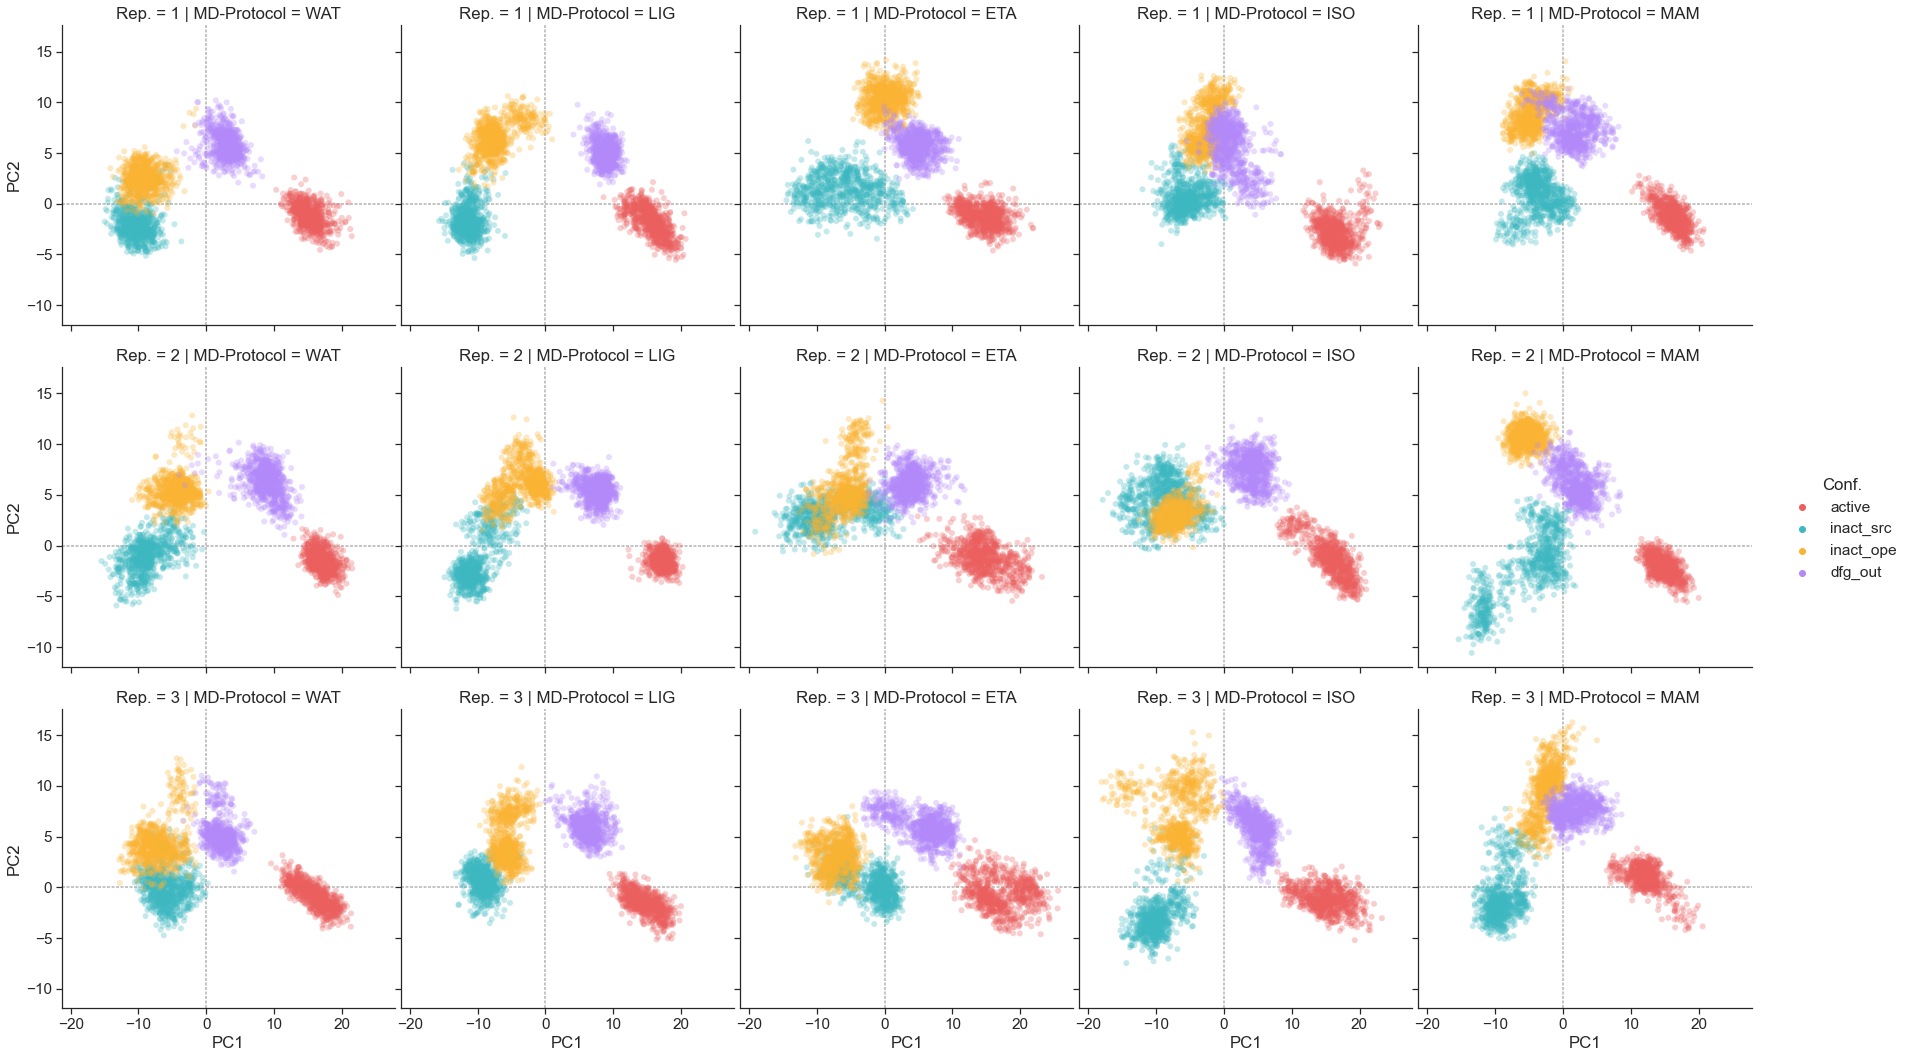

In [23]:
g = sns.relplot(x= 1, y= 2,
                hue="Conf.", 
                row = "Rep.", 
                col = 'MD-Protocol',
                kind = 'scatter',
                palette = conf_label_colors,
                linewidth = 0,
                alpha = 0.3,
                data = df_md)
(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .map(plt.axvline, x=0, color=".7", dashes=(2, 1), zorder=0)
  .map(plot_initial_confs, ax = ax, pca = pca)
  .set_axis_labels("PC1", "PC2")
  .tight_layout(w_pad=0)
)

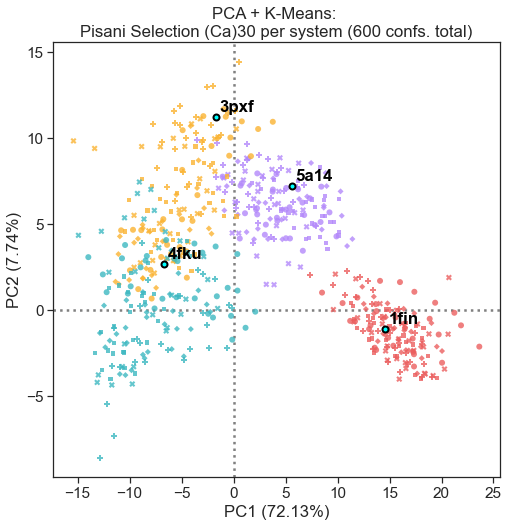

In [24]:
n_clusters = 30
n_components_to_use = 3
COL_HUE = 'Conf.'
DF_PROJ = df_md[['Conf.', 'Rep.', 'MD-Protocol'] + \
               list(range(1, n_components_to_use + 1))]
PLOT_TITLE = 'PCA + K-Means: \nPisani Selection (Ca)' +\
             f'{n_clusters} per system ({n_clusters * 20} confs. total)'

df_meds = get_medoid_confs(df_all_systems=DF_PROJ,
                 used_stride=STRIDE_MD,
                 n_clusters=30)

ax = plot_projection(df = df_meds, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     legend = False,
                     alpha = 0.8,
                     style = 'MD-Protocol',
                     palette = conf_label_colors)
plot_initial_confs(ax = ax, pca = pca)
plt.show()

In [25]:
# Save the dataframe with the medoid confs
proj_type = 'MDconfsOnCRYSconfs'
selection = 'Pisani'
filename  = f'./kMedoid_{proj_type}_{selection}Selection'
df_meds.to_pickle(filename)

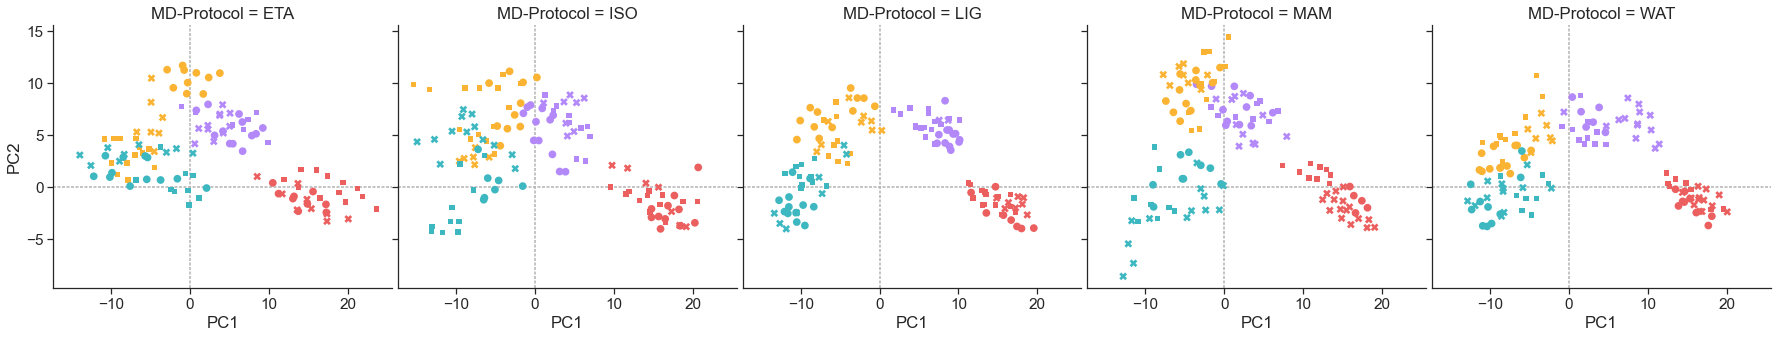

In [26]:
g = sns.relplot(x= 1, y= 2,
                hue="Conf.", 
#                 row = "Rep.", 
                col = 'MD-Protocol',
                kind = 'scatter',
                style = 'Rep.',
                palette = conf_label_colors,
                linewidth = 0,
                alpha = 1,
                legend = False,
                s = 60,
                data = df_meds)
(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .map(plt.axvline, x=0, color=".7", dashes=(2, 1), zorder=0)
  .map(plot_initial_confs, ax = ax, pca = pca)
  .set_axis_labels("PC1", "PC2")
  .tight_layout(w_pad=0)
)

## Pocket Selection

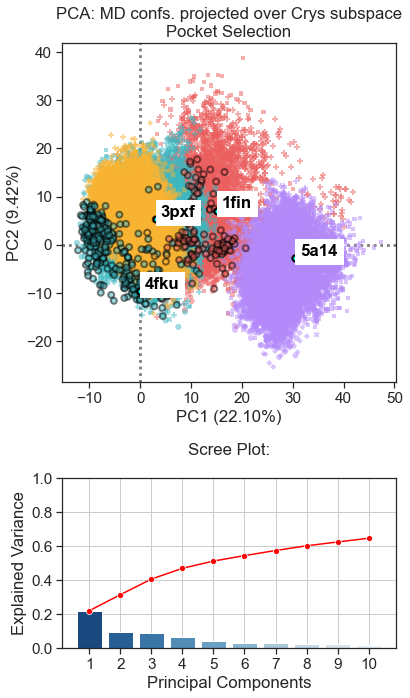

In [27]:
TRAJ    = crys_traj
MASK    = mask_pkt_noHs
STRIDE  = 1
DF_PLOT = df_prot[['PDB_ID', 'ConfTypeLabel']]
PLOT_TITLE = 'PCA: MD confs. projected over Crys subspace\n' +\
             'Pocket Selection'
n_components = 10
# Crys projection
mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
df_proj, exp_vars, pca = get_pca_projs(mtx_coords = mtx_coords, 
                                  df_labels = DF_PLOT, 
                                  stride = STRIDE,
                                  n_components = n_components)

# Project MD conformations
TRAJ = md_trajs
md_mtx_coords = get_coords(traj = TRAJ, 
                        mask = MASK, ref_conf = ref_conf, 
                        stride = STRIDE)
md_projs = pca.transform(md_mtx_coords)
df_md = df_md_projs\
        .replace(pdbid_confTypes)[['Conf.', 'Rep.', 'MD-Protocol']]
df_md = pd.concat((df_md, 
                    pd.DataFrame(md_projs,
                    columns = range(1, n_components + 1),
                                )), 
                    axis = 1)
# Plot
fig, axs = plt.subplots(2, 1, figsize = (6, 10),
                       gridspec_kw={'height_ratios':[2,1]})
COL_HUE = 'Conf.'
plot_projection(df = df_md, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     style = 'MD-Protocol',
                     ax = axs[0],
                     legend = False,
                     palette = conf_label_colors)
COL_HUE = 'ConfTypeLabel'
plot_projection(df = df_proj, color_hue = COL_HUE,  
                 plot_title = PLOT_TITLE,
                 exp_vars = exp_vars, 
                 legend = False,
                 linewidth = 2, edgecolor = 'black',
                 palette = conf_label_colors, ax = axs[0])

# Reference conformations
plot_initial_confs(axs[0], pca, 
                   xy_text_displace = (1, 0.5),
                   bbox = dict(
                     boxstyle  = "square",
                     facecolor = 'white')
                   )
# Scree plot
plot_explained_variance(pca_obj = pca, ax = axs[1])
plt.tight_layout()
plt.show()

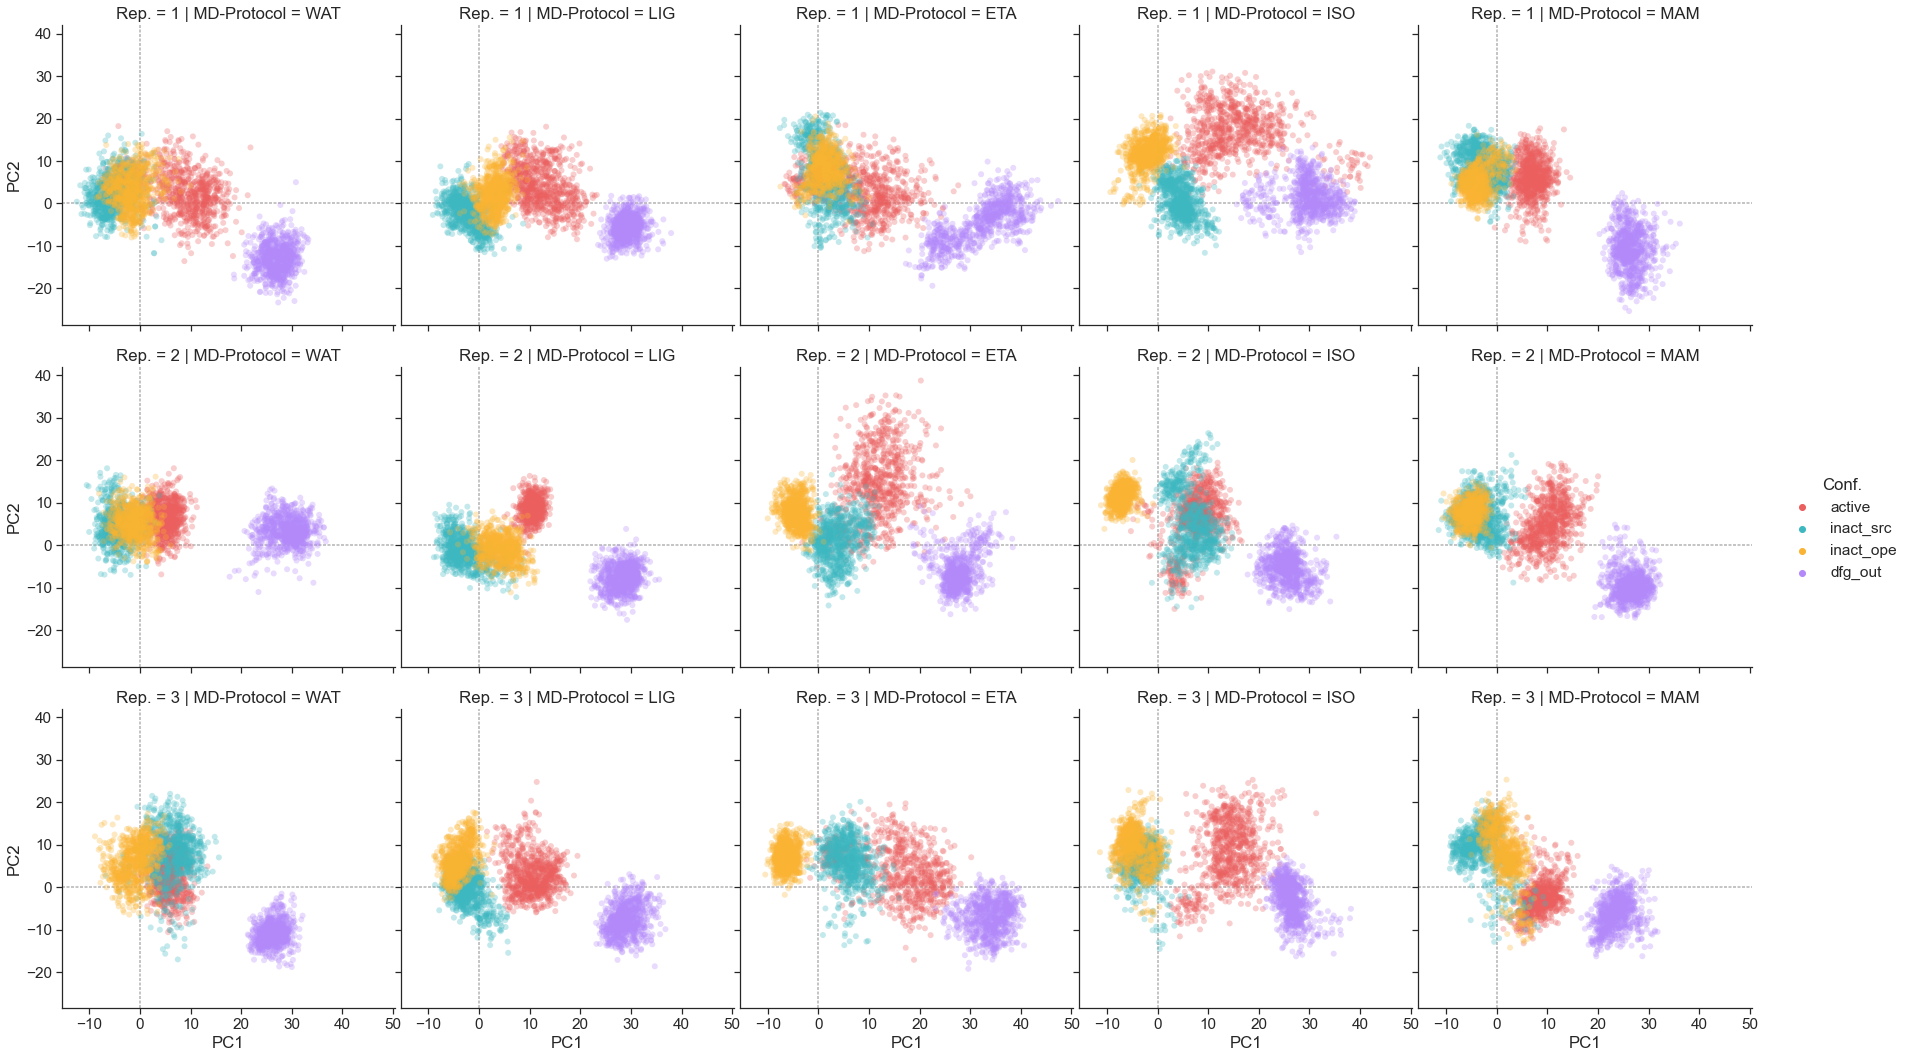

In [28]:
g = sns.relplot(x= 1, y= 2,
                hue="Conf.", 
                row = "Rep.", 
                col = 'MD-Protocol',
                kind = 'scatter',
                palette = conf_label_colors,
                linewidth = 0,
                alpha = 0.3,
                data = df_md)
(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .map(plt.axvline, x=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("PC1", "PC2")
  .tight_layout(w_pad=0)
)

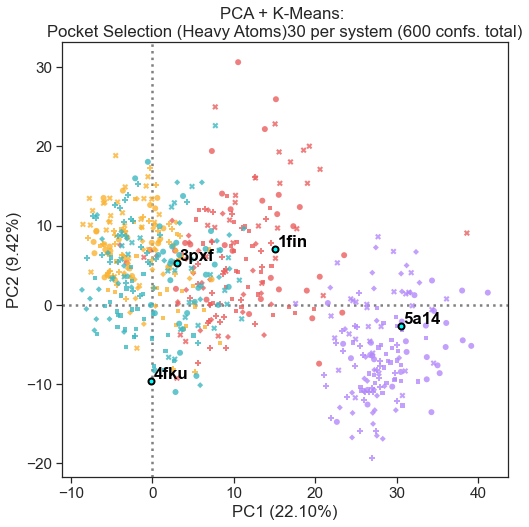

In [29]:
n_clusters = 30
n_components_to_use = 8
COL_HUE = 'Conf.'
DF_PROJ = df_md[['Conf.', 'Rep.', 'MD-Protocol'] + \
               list(range(1, n_components_to_use + 1))]
PLOT_TITLE = 'PCA + K-Means: \nPocket Selection (Heavy Atoms)' +\
             f'{n_clusters} per system ({n_clusters * 20} confs. total)'

df_meds = get_medoid_confs(df_all_systems=DF_PROJ,
                 used_stride=STRIDE_MD,
                 n_clusters=30)

ax = plot_projection(df = df_meds, color_hue = COL_HUE,  
                     plot_title = PLOT_TITLE,
                     exp_vars = exp_vars, 
                     legend = False,
                     alpha = 0.8,
                     style = 'MD-Protocol',
                     palette = conf_label_colors)
plot_initial_confs(ax = ax, pca = pca)
plt.show()

In [30]:
# Save the dataframe with the medoid confs
proj_type = 'MDconfsOnCRYSconfs'
selection = 'Pocket'
filename  = f'./kMedoid_{proj_type}_{selection}Selection'
df_meds.to_pickle(filename)

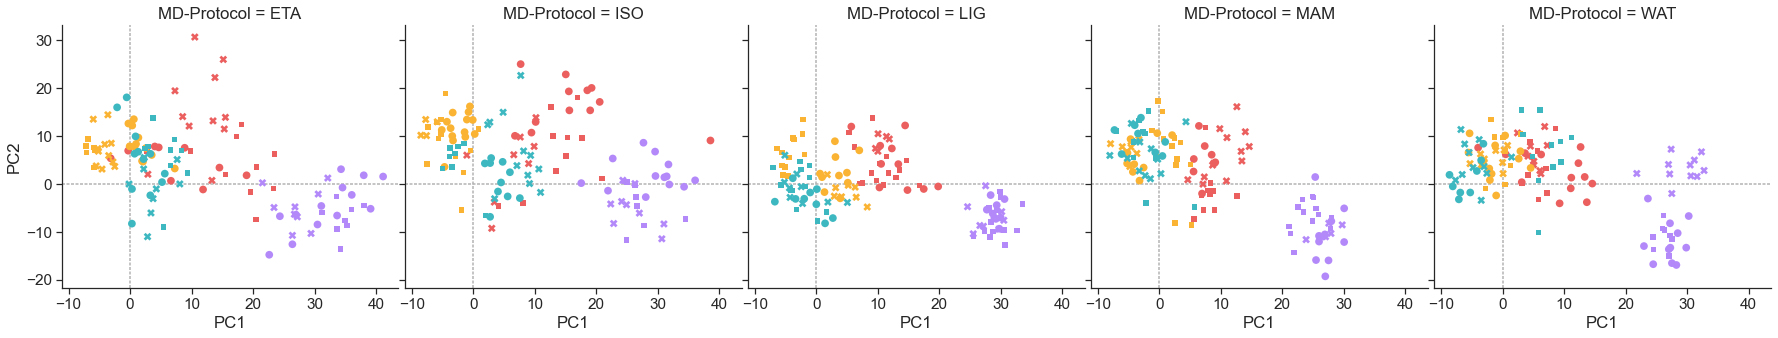

In [31]:
g = sns.relplot(x= 1, y= 2,
                hue="Conf.", 
#                 row = "Rep.", 
                col = 'MD-Protocol',
                kind = 'scatter',
                style = 'Rep.',
                palette = conf_label_colors,
                linewidth = 0,
                alpha = 1,
                legend = False,
                s = 60,
                data = df_meds)
(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .map(plt.axvline, x=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("PC1", "PC2")
  .tight_layout(w_pad=0)
)